In [1]:
!python -m spacy download en_core_web_sm

2023-11-13 13:25:42.078342: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-13 13:25:42.209090: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-13 13:25:42.213477: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-13 13:25:42.213501: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
!pip install xgboost==2.0.1


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip install catboost==1.2.2


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
!pip install optuna==3.4.0


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

#NLP libraries
import re
import spacy
import string
from sklearn.feature_extraction.text import TfidfVectorizer


#ML and models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

import pickle

import optuna


/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-13 13:25:56.447046: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-13 13:25:56.567240: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-13 13:25:56.571473: W tensorflow/stream_executor/platform/default/dso_loader.

## Import of dataset and first investigation

In [6]:
df = pd.read_csv("youtoxic_english_1000.csv")
df.head()

,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,False,False,False,False,False,False,False,False,False,False,False,False
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,True,True,False,False,False,False,False,False,False,False,False,False
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\nDont you reckon them 'black lives matter' ba...,True,True,False,False,True,False,False,False,False,False,False,False
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do...,False,False,False,False,False,False,False,False,False,False,False,False
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should h...",False,False,False,False,False,False,False,False,False,False,False,False


In [7]:
df.shape

(1000, 15)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   CommentId        1000 non-null   object
 1   VideoId          1000 non-null   object
 2   Text             1000 non-null   object
 3   IsToxic          1000 non-null   bool  
 4   IsAbusive        1000 non-null   bool  
 5   IsThreat         1000 non-null   bool  
 6   IsProvocative    1000 non-null   bool  
 7   IsObscene        1000 non-null   bool  
 8   IsHatespeech     1000 non-null   bool  
 9   IsRacist         1000 non-null   bool  
 10  IsNationalist    1000 non-null   bool  
 11  IsSexist         1000 non-null   bool  
 12  IsHomophobic     1000 non-null   bool  
 13  IsReligiousHate  1000 non-null   bool  
 14  IsRadicalism     1000 non-null   bool  
dtypes: bool(12), object(3)
memory usage: 35.3+ KB


In [9]:
df.isnull().sum()

CommentId          0
VideoId            0
Text               0
IsToxic            0
IsAbusive          0
IsThreat           0
IsProvocative      0
IsObscene          0
IsHatespeech       0
IsRacist           0
IsNationalist      0
IsSexist           0
IsHomophobic       0
IsReligiousHate    0
IsRadicalism       0
dtype: int64

In [10]:
df.nunique()

CommentId          1000
VideoId              13
Text                997
IsToxic               2
IsAbusive             2
IsThreat              2
IsProvocative         2
IsObscene             2
IsHatespeech          2
IsRacist              2
IsNationalist         2
IsSexist              2
IsHomophobic          1
IsReligiousHate       2
IsRadicalism          1
dtype: int64

In [11]:
col = list(df.columns)
for col_name in col:
  print(f'Name: {col_name}')
  print(df[col_name].value_counts())

Name: CommentId
UgjDNWUuHfmW8ngCoAEC    1
UgilSzQ81KO3zngCoAEC    1
UghRGM0aDMSjRXgCoAEC    1
Ugj3_gxzwZGN93gCoAEC    1
UgiWauybsgSl7XgCoAEC    1
                       ..
Ugh0tf8ZI_s6z3gCoAEC    1
UggLbJp619j8BHgCoAEC    1
UgiovVFNjWPUJngCoAEC    1
UghkXLn32ypsD3gCoAEC    1
Ugg9a6FtoXdxmXgCoAEC    1
Name: CommentId, Length: 1000, dtype: int64
Name: VideoId
9pr1oE34bIM    274
04kJtp6pVXI    172
cT14IbTDW2c    146
dG7mZQvaQDk    112
TZxEyoplYbI    104
bUgKZMSxr3E     39
8HB18hZrhXc     38
4rCweDxDqdw     37
Dt9-byUhPdg     34
#NAME?          16
dDbRyFIkNII     10
XRuCW80L9mA     10
5vF4si3hoRA      8
Name: VideoId, dtype: int64
Name: Text
run them over                                                                                                                                                                                                                                                                                                                                                     

In [12]:
duplicates = df[df.duplicated('Text', keep=False)]
duplicate_values = duplicates['Text'].tolist()
print(duplicate_values)


['RUN THEM OVER', 'run them over', 'run them over', 'run them over', 'RUN THEM OVER']


## Conversion from object to int and creation new summarising column hate or not

In [13]:
bool_col = df.select_dtypes(include = ['bool'])
# Convert boolean columns to integers
df[bool_col.columns] = df[bool_col.columns].astype(int)
df.head()

,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,0,0,0,0,0,0,0,0,0,0,0,0
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,1,1,0,0,0,0,0,0,0,0,0,0
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\nDont you reckon them 'black lives matter' ba...,1,1,0,0,1,0,0,0,0,0,0,0
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do...,0,0,0,0,0,0,0,0,0,0,0,0
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should h...",0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
df_sumhate = df.copy()
df_sumhate.shape

(1000, 15)

In [15]:
df_sumhate['Hate'] = df_sumhate.select_dtypes( include= ['int']).any(axis=1).astype(int)
df_sumhate.head()

,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism,Hate
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,1,1,0,0,0,0,0,0,0,0,0,0,1
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\nDont you reckon them 'black lives matter' ba...,1,1,0,0,1,0,0,0,0,0,0,0,1
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do...,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should h...",0,0,0,0,0,0,0,0,0,0,0,0,0


### Investigate targeted variable 

/tmp/ipykernel_321/374701907.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(11, 4, index)


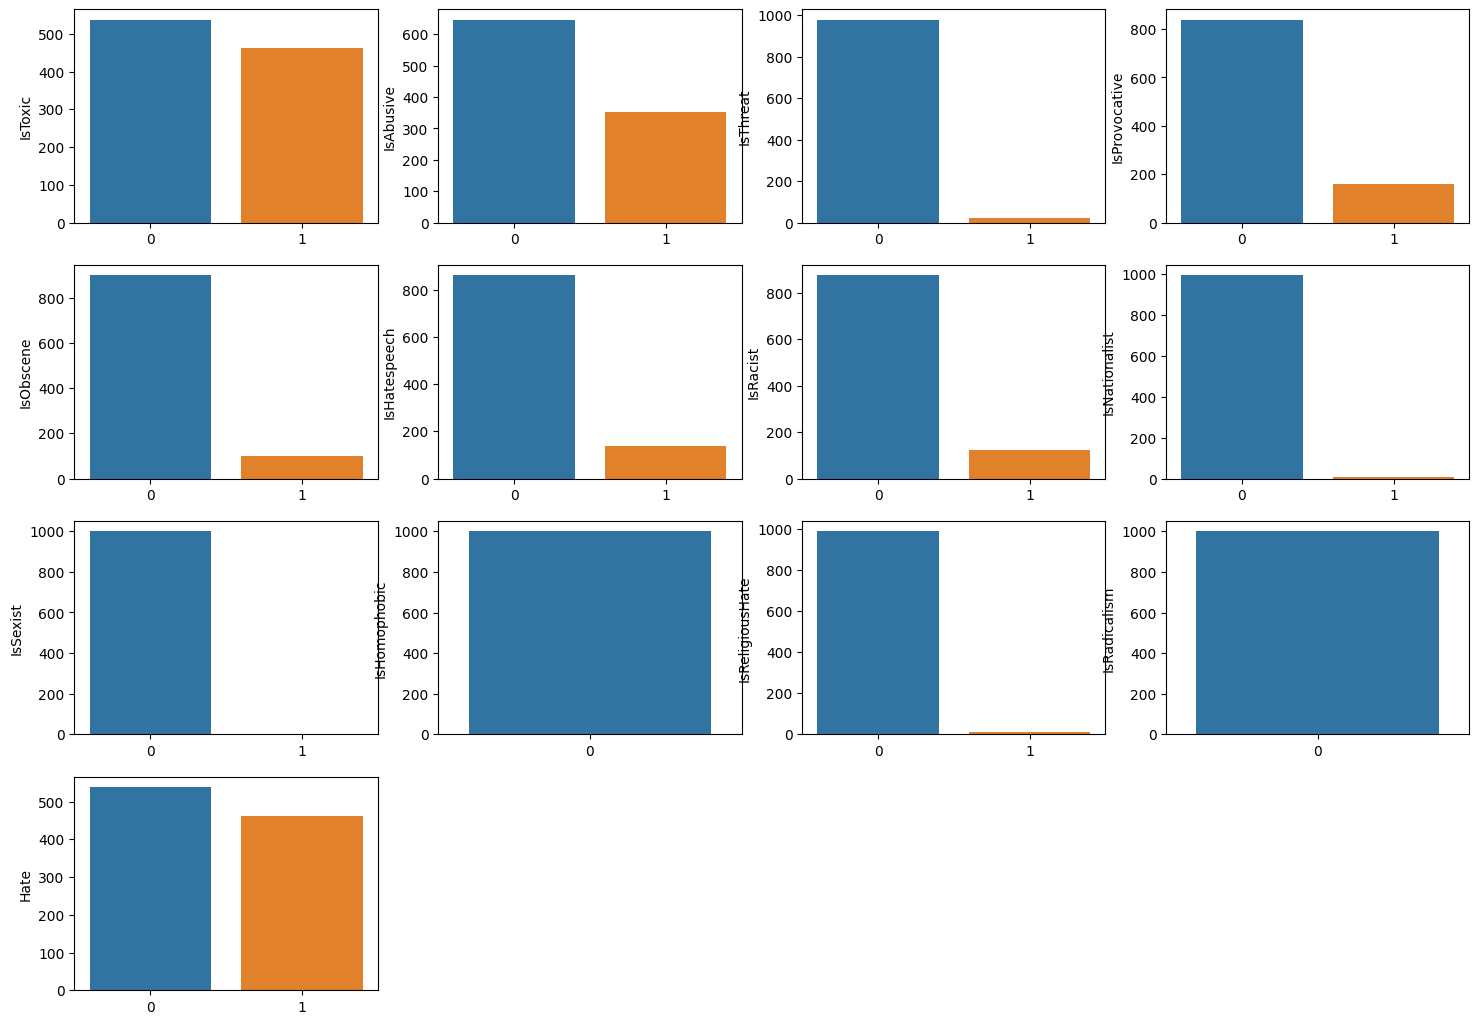

In [16]:
plt.figure(figsize=(18, 36))
plt.title("Features Distribution")
plt.xticks(rotation=90)
index = 1
col_hate = df_sumhate.select_dtypes(include= ['int'])

for col in col_hate:
    y = df_sumhate[col].value_counts()
    plt.subplot(11, 4, index)
    sns.barplot(x=list(y.index), y=y)
    index += 1


Looking at different "kind of hate" comments distribution some of them looks very unbalanced but if we look at resumen "hate" column it looks quite balanced

## Text cleaning with spacy

In [17]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [18]:

nlp = spacy.load('en_core_web_sm')

In [19]:
stopwords = spacy.lang.en.stop_words.STOP_WORDS
print(len(stopwords))

326


In [20]:
#function to clean the text 

def clean_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # eliminate URL
    text = re.sub(r'@\w+', '', text)  # eliminate  mentions
    text = re.sub(r'#\w+', '', text)  # eliminate  hashtags
    text = re.sub(r'[^\x00-\x7F]+', '', text)  #specific symbols which are not in ASCII
    text = re.sub(r'\d+', '', text)  # eliminate numbers
    tokens = nlp(text)  # tokenization with spacy
    text = " ".join([word.lemma_ for word in tokens if word.lemma_ not in stopwords])  #checking stopwords plus lematization
    text = re.sub(r'\s+', ' ', text).strip() # eliminate extra space
    text = re.sub(r'[^\w\s]', '', text)  # eliminate punctuation

    return text.lower() 


df_sumhate['processed_text'] = df_sumhate['Text'].apply(lambda x: clean_text(x))
df_sumhate.head()


,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism,Hate,processed_text
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,0,0,0,0,0,0,0,0,0,0,0,0,0,people step case people situation lump mess ...
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,1,1,0,0,0,0,0,0,0,0,0,0,1,law enforcement train shoot apprehend train s...
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\nDont you reckon them 'black lives matter' ba...,1,1,0,0,1,0,0,0,0,0,0,0,1,reckon black life matter banner hold white c...
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do...,0,0,0,0,0,0,0,0,0,0,0,0,0,large number people like police officer crimi...
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should h...",0,0,0,0,0,0,0,0,0,0,0,0,0,arab dude absolutely right shoot extra time ...


In [21]:
print(len(df_sumhate['Text'][0]))
print(len(df_sumhate['processed_text'][0]))

1558
672


In [22]:
df_final= df_sumhate[['processed_text', 'Hate']]
df_final.head()

,processed_text,Hate
0,people step case people situation lump mess ...,0
1,law enforcement train shoot apprehend train s...,1
2,reckon black life matter banner hold white c...,1
3,large number people like police officer crimi...,0
4,arab dude absolutely right shoot extra time ...,0


## Vectorisation with TF-IDF 

In [23]:
tfv = TfidfVectorizer(ngram_range=(1, 2),max_df=0.7, min_df=3, max_features=5000)

X_tfv =  tfv.fit_transform(df_final['processed_text'])
X_tfv.shape

(1000, 1160)

In [24]:
print(tfv.get_feature_names_out())

['ability' 'able' 'absolutely' ... 'youtube' 'zimmerman' 'zimmerman case']


In [25]:
X_features = pd.DataFrame(X_tfv.toarray())
X_features.columns = tfv.get_feature_names_out()
y = df_final['Hate']
X_features.head()


,ability,able,absolutely,abuse,accord,account,accountable,act,act like,action,...,yea,yeah,year,year old,yes,young,young man,youtube,zimmerman,zimmerman case
0,0.0,0.0,0.00000,0.0,0.0,0.0,0.124136,0.0,0.0,0.209767,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.21855,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Holdout set

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2)

In [27]:
X_train1=X_train.copy()
y_train1=y_train.copy()

## RandomForest 

In [28]:
# train the model
rf = RandomForestClassifier(n_estimators= 50, n_jobs=-1, max_depth=20)
rf_model = rf.fit(X_train1, y_train1)

In [29]:
# checkin feature importance: 10 most valuable features in deccending order zipped with columns names 

sorted(zip(rf_model.feature_importances_, X_train1.columns),reverse=True)[0:10]

[(0.05525531704966067, 'fuck'),
 (0.040465199419967866, 'run'),
 (0.0242967137138482, 'stupid'),
 (0.023485099029923063, 'bitch'),
 (0.023189131307853716, 'shit'),
 (0.02118671681732093, 'video'),
 (0.020126366517826604, 'ass'),
 (0.019652676450770463, 'kill'),
 (0.018737689755968436, 'idiot'),
 (0.01830863296622939, 'thug')]

In [30]:
#predictions and metrics calculations
y_pred = rf_model.predict(X_test)
#Define a prediction function for the given model
report = classification_report( y_test, y_pred)
print(report)
acc=accuracy_score(y_test,y_pred)
train_pred = rf_model.predict(X_train1)
acc_train = accuracy_score(y_train1,train_pred)
overfitting = (acc_train-acc)*100 
print("Accuracy Score:" , acc)
print("Overfitting:"  , overfitting)


              precision    recall  f1-score   support

           0       0.68      0.93      0.79       104
           1       0.88      0.53      0.66        96

    accuracy                           0.74       200
   macro avg       0.78      0.73      0.73       200
weighted avg       0.78      0.74      0.73       200

Accuracy Score: 0.74
Overfitting: 12.124999999999996


array([[97,  7],
       [45, 51]])

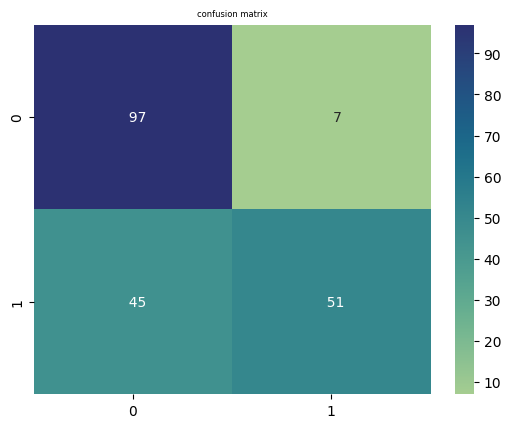

In [31]:
conf_mx = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_mx, annot=True, fmt='4.0f', cmap='crest')
plt.title('confusion matrix', size=6)
conf_mx

In [32]:
# parameter search with optuna

def objective(trial):
    # Number of trees in random forest
    n_estimators = trial.suggest_int(name="n_estimators", low=10, high=200, step=10)

    # Number of features to consider at every split
    max_features = trial.suggest_categorical(name="max_features", choices=['auto', 'sqrt']) 

    # Maximum number of levels in tree
    max_depth = trial.suggest_int(name="max_depth", low=10, high=50, step=5)

    # Minimum number of samples required to split a node
    min_samples_split = trial.suggest_int(name="min_samples_split", low=2, high=10, step=2)

    # Minimum number of samples required at each leaf node
    min_samples_leaf = trial.suggest_int(name="min_samples_leaf", low=1, high=4, step=1)
    
    params = {
        "n_estimators": n_estimators,
        "max_features": max_features,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf
    }
    model = RandomForestClassifier(**params)
    
    cv_score = cross_val_score(model, X_train1, y_train1, n_jobs=-1, cv=5)
    mean_cv_accuracy = cv_score.mean()
    return mean_cv_accuracy

study = optuna.create_study()
study.optimize(objective, n_trials=5)

# Train a new model using the best parameters
best_model = RandomForestClassifier(**study.best_params)
best_model.fit(X_train1, y_train1)

y_pred = best_model.predict(X_test)
pred_train = best_model.predict(X_train1)


acc = round(accuracy_score(y_test, y_pred), 3)
acc_train = round(accuracy_score(y_train1, pred_train), 3)
precision, recall, f1, _ = score(y_test, y_pred, average='binary')
#overfit_acc = ((scores['train_accuracy']) - accuracy) * 100
overfitting = (acc_train-acc)*100 
print("Accuracy: {} || Precision: {} || Recall: {} || F1: {} || Overfit%: {}".format(acc, precision, recall, f1, overfitting ))

[I 2023-11-13 13:26:10,921] A new study created in memory with name: no-name-bac1d014-2734-42fa-ac6c-a5737da70699
[I 2023-11-13 13:26:13,098] Trial 0 finished with value: 0.7037500000000001 and parameters: {'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 40, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.7037500000000001.
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter a

## Preprocessor

In [33]:
#creating transformer from cleaning function
func_trans_clean = FunctionTransformer(clean_text)

In [34]:
preprocessor = Pipeline([('clean', func_trans_clean),('tfv', TfidfVectorizer())])

## Resume

The best result of Random Forest model : Accuracy -74%, Precision - 78%, Recall -74%, F1 - 73% with level of Overfiting -12,2%
The overfitting can be adjusted up to 6,4% with negative impact on recall:  Accuracy -72,5%; Precision -85,96%; Recall - 51%; F1 - 64%  based on Optuna parameter search results.

To improve RF model results have been changed cleaning steps and TF-IDF parameters (ngram_range=(1, 2),max_df=0.7, min_df=3, max_features=5000)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d8103776-8bc3-42d5-af3b-9ad38442056c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>